## notebook dedicated to feature extraction from dead-ends processed data

#### we'll explore some information that can be taken from the input inmages and be used as input for a neural network too

#### **potential features**

- Porosity: $\phi$ = P/T

- permeability estimation: k = $\phi$³/((1-$\phi$²)*T²)

- tortuosity: $\tau$ = L_real/L_direto (l_real is calculated using `Dijkstra algorithm`)

In [11]:
from PIL import Image
from random import randint
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#### 1. porosity

In [26]:
def is_rock(pixel, threshold):
    """
    check if a triple is of white spectrum, if yes returns 1, if no returns 0
    """
    r, g, b = pixel
    if (r > threshold) and (g > threshold) and (b > threshold):
        return 1
    return 0

def fluid_mask(img: np.ndarray):
    """
    Creates a mask that assumes value 1 for regions where fluid is present and value 0 otherwise
    """
    mask = np.zeros([200, 200])
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel = img[i, j, :]
            if(is_rock(pixel, 110)):
                mask[i, j] = 0
            else:
                mask[i, j] = 1
    return mask

img = np.array(Image.open(r'C:\Users\Juliet\Desktop\Vinicius\deadend\data\input\1.png'))
mask = fluid_mask(img)


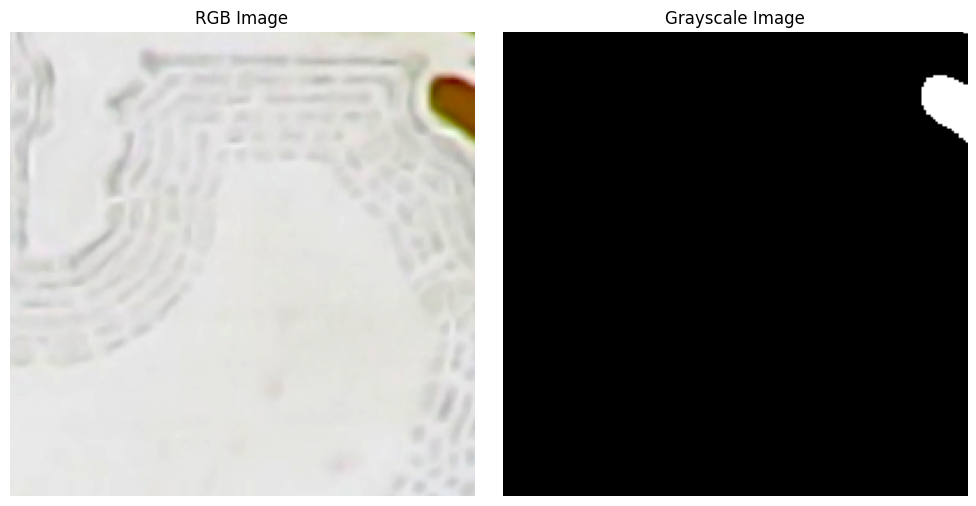

In [27]:
# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the RGB image
axes[0].imshow(img)
axes[0].set_title("RGB Image")
axes[0].axis("off")

# Display the grayscale image
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Grayscale Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [28]:
# calculate porosity

phi = (np.sum(mask == 1)/ (200 * 200)).item()
phi

0.01015

#### 2. tortuosity

In [32]:
def calculate_tortuosity(mask, start, end):
    """
    Calculate tortuosity using Dijkstra algorithm.
    - mask: binary mask.
    - start: tuple (x, y) start coordinates.
    - end: tuple (x, y) end coordinates.
    """
    G = nx.grid_2d_graph(*mask.shape)
    for (x, y) in list(G.nodes):
        if mask[x, y] == 0:
            G.remove_node((x, y))

    for edge in G.edges:
        G.edges[edge]['weight'] = 1

    try:
        path = nx.shortest_path(G, source=start, target=end, weight='weight')
        length_real = nx.shortest_path_length(G, source=start, target=end, weight='weight') # djikstra algorithm
    except nx.NetworkXNoPath:
        return None
    length_direct = np.linalg.norm(np.array(start) - np.array(end))
    tau = length_real / length_direct
    return tau

start = (0, 0)  # start point
end = (3, 10)  # end point

while mask[start[0], start[1]] == 0:
    start = (start[0] + 1, start[1] + 1)

while mask[end[0], end[1]] == 0:
    end = (end[0] - 1, end[1] - 1)

tortuosity = calculate_tortuosity(mask, start, end)

if tortuosity:
    print(f"Tortuosity calculated: {tortuosity:.4f}")

IndexError: index 200 is out of bounds for axis 0 with size 200

In [33]:
# set of all possible coordenates for chossing points

def list_points(img_array: np.ndarray):
    valid_points = []
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            if img_array[i, j] == 1:
                valid_points.append((i, j))
    return valid_points

In [34]:
# make an iterative tortuosity calculator

valid_points = list_points(mask)

def iterative_tortuosity(mask, n, valids):

    final_tortuosity = 0.0
    denominator = n
    for i in range(0, n):
        start = valids[randint(0, len(valids)-1)]
        end = valids[randint(0, len(valids)- 1)]
        while (start[0] == end[0] and start[1] == end[1]):
            end = valids[randint(0, len(valids)- 1)]
        tortuosity = calculate_tortuosity(mask, start, end)
        if tortuosity == None:
            denominator -= 1
            continue
        else:
            final_tortuosity += tortuosity
    
    return (final_tortuosity/denominator).item()
        




In [35]:
iterative_tortuosity(mask, 200, valid_points)

1.2768565255167599

#### 3. permeability kozeny-carman equation variation

In [36]:
k = (phi**3)/((1 - phi)**2 * iterative_tortuosity(mask, 50, valid_points)**2)

In [37]:
k

6.66673170905615e-07